# Introduction

To optimize the trained model with the MNIST dataset the images generated by the [online demo](https://flask-mnist.herokuapp.com/) were saved and can be downloaded from demo page.

This notebook considers that the samples have been downloaded and decompressed into a folder called `mnist` from the current directory.

# Categoring

The images, as they were drawn by the interface of the demo, were saved in size 28x28 with white background and black foreground.

The prediction made by the demo was saved as part of the file name in the following format:

[predicted]-[datetime].png

Below we will iterate over these images, show them on the screen and enter the correct category. **Relax, this has already been done for you.**

In [54]:
import os
import time

from PIL import Image
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
path = 'mnist/'
valid_inputs = []
valid_labels = []

for filename in os.listdir(path):
    img = Image.open('%s%s' % (path, filename))
    plt.figure()
    plt.title('Predicted as: %s' % filename.split('-')[0])
    plt.imshow(img)
    plt.show()
    label = input('What number is?')
    if label:
        valid_inputs.append(img)
        valid_labels.append(int(label))
    time.sleep(0.1)
    clear_output()

As we see below, we have 910 good images to use.

In [55]:
len(valid_inputs)

910

In [56]:
len(valid_labels)

910

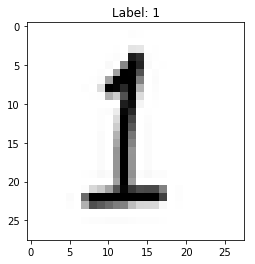

In [57]:
def show_inputs(idx):
    plt.title('Label: %s' % valid_labels[idx])
    plt.imshow(valid_inputs[idx])

show_inputs(42)

Now, we'll save these images and the right label in disk to offer them to download.

In [60]:
!mkdir mnist/validated/

In [61]:
for img, label in zip(valid_inputs, valid_labels):
    old_name = img.filename.split('/')[2]
    new_name = 'mnist/mnist/validated/%s-%s' % (label, old_name.split('-')[1])
    img.save(new_name)

In [66]:
import numpy as np

def do_array(img):
    temp = img
    temp = temp.convert('1')
    A = np.array(temp)
    new_A = np.empty((A.shape[0], A.shape[1]), None)

    for i in range(len(A)):
        for j in range(len(A[i])):
            if A[i][j] == True:
                new_A[i][j] = 0
            else:
                new_A[i][j] = 1
    return new_A

To make it easier to load the data, let's also save the arrays

In [78]:
convert_inputs = [do_array(img).reshape([784]) for img in valid_inputs]

In [155]:
convert_inputs = np.array(convert_inputs)
np.save('convert_inputs', convert_inputs)
np.save('valid_labels', valid_labels)

# Checkpoint

If you got here or have the saved data in disk, you can continue from here.

In [1]:
import os
import time
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

convert_inputs = np.load('convert_inputs.npy')
valid_labels = np.load('valid_labels.npy')

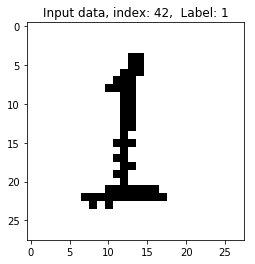

In [2]:
def show_digit(index):
    label = valid_labels[index]
    image = convert_inputs[index].reshape([28,28])
    plt.title('Input data, index: %d,  Label: %d' % (index, label))
    plt.imshow(image, cmap='gray_r')
    plt.show()
    
show_digit(42)

To train the model or compare its performance, you need to adjust the labels in the one-hot-encoding model

In [3]:
one_hot_labels = []

for label in valid_labels:
    one_hot = list([0]*9)
    one_hot.insert(label, 1)
    one_hot_labels.append(np.asarray(one_hot))

one_hot_labels = np.asarray(one_hot_labels)
print(one_hot_labels[42])
print(valid_labels[42])

[0 1 0 0 0 0 0 0 0 0]
1


Here we re-create the model and load the trainig data

In [4]:
import tensorflow as tf
import tflearn

def build_model():
    tf.reset_default_graph()
    net = tflearn.input_data([None, 784])

    net = tflearn.fully_connected(net, 300, activation='ReLU')
    net = tflearn.fully_connected(net, 100, activation='ReLU')

    net = tflearn.fully_connected(net, 10,  activation='softmax')

    net = tflearn.regression(net, optimizer='sgd', learning_rate=0.05, loss='categorical_crossentropy')

    model = tflearn.DNN(net)
    return model

model = build_model()
model.load('webapp/MNIST.tfl')

INFO:tensorflow:Restoring parameters from /home/rafael/prj/mnist/code/webapp/MNIST.tfl


In [5]:
predictions = np.array(model.predict(convert_inputs)).argmax(axis=1)
actual = one_hot_labels.argmax(axis=1)
test_accuracy = np.mean(predictions == actual, axis=0)
print("Test accuracy: ", test_accuracy)

Test accuracy:  0.463736263736


The data generated by the demo were processed and used to verify the accuracy of the model. We have a 46% success rate.

In [9]:
img = convert_inputs[42]
img = img.reshape([28,28])

In [12]:
test = np.ones(4).reshape([2,2])
test

array([[ 1.,  1.],
       [ 1.,  1.]])

In [18]:
np.pad(test, pad_width=2, mode='constant')

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [42]:
new_img = np.pad(img, pad_width=10, mode='constant')

In [43]:
def crop_center(img,cropx,cropy):
    y, x = img.shape
    startx = x//2 - (cropx//2)
    starty = y//2 - (cropy//2)    
    return img[starty:starty+cropy, startx:startx+cropx]

In [44]:
from scipy.ndimage.measurements import center_of_mass

In [45]:
x, y = center_of_mass(new_img)

In [46]:
crop_center(img, x, y)

TypeError: slice indices must be integers or None or have an __index__ method